# O1 Data Generation with CAMEL and Upload Data to Huggingface

You can also check this cookbook in colab [here](https://drive.google.com/file/d/1oGFFuhaiQgGPieT4BwbfAWEdV-L5cJQz/view?usp=sharing)  (Use the colab share link)



This notebook demonstrates how to set up and leverage CAMEL's **O1DataGenerator** for generating high-quality question-answer pairs like o1 thinking data, uploading the data to Hugging Face.

In this notebook, you'll explore:

- **CAMEL**: A powerful multi-agent framework that enables SFT data generation and multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
- **O1DataGenerator**: A tool for generating like o1 thinking data.

- **Hugging Face Integration**: Uploading datasets  to the Hugging Face platform for sharing


⭐ **Star the Repo**

If you find CAMEL useful or interesting, please consider giving it a star on our [CAMEL GitHub Repo](https://github.com/camel-ai/camel)! Your stars help others find this project and motivate us to continue improving it.

## 📦 Installation

In [ ]:
%%capture
!pip install camel-ai==0.2.15a0

In [ ]:
import os
from datetime import datetime
import json
from camel.datagen.o1datagen import O1DataGenerator

## 🔑 Setting Up API Keys

First we will set the OPENAI_API_KEY that will be used to generate the data.



In [ ]:
from getpass import getpass

In [ ]:
openai_api_key = getpass('Enter your OpenAI API key: ')
os.environ["OPENAI_API_KEY"] = openai_api_key

Enter your OpenAI API key: ··········


## Set ChatAgent

Create a system message to define agent's default role and behaviors.

In [ ]:
sys_msg = 'You are a genius at slow-thinking data and code'

Use ModelFactory to set up the backend model for agent

CAMEL supports many other models. See [here](https://docs.camel-ai.org/key_modules/models.html) for a list.

In [ ]:
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import ChatGPTConfig

In [ ]:
# Define the model, here in this case we use gpt-4o-mini
model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O_MINI,
    model_config_dict=ChatGPTConfig().as_dict(), # [Optional] the config for model
)

In [ ]:
from camel.agents import ChatAgent
chat_agent = ChatAgent(
    system_message=sys_msg,
    model=model,
    message_window_size=10,
)

## Load Q&A data from a JSON file

### please prepare the qa data like below in json file:

'''
{
    "question1": "answer1",
    "question2": "answer2",
    ...
}
'''

In [ ]:
!pwd

/content


The script fetches a example JSON file containing question-answer pairs from a GitHub repository and saves it locally. The JSON file is then loaded into the qa_data variable.

In [ ]:
#get example json data

import requests
import json

# URL of the JSON file
url = 'https://raw.githubusercontent.com/zjrwtx/alldata/refs/heads/main/qa_data.json'

# Send a GET request to fetch the JSON file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the response content as JSON
    json_data = response.json()

    # Specify the file path to save the JSON data
    file_path = 'qa_data.json'

    # Write the JSON data to the file
    with open(file_path, 'w', encoding='utf-8') as json_file:
        json.dump(json_data, json_file, ensure_ascii=False, indent=4)

    print(f"JSON data successfully saved to {file_path}")
else:
    print(f"Failed to retrieve JSON file. Status code: {response.status_code}")

JSON data successfully saved to qa_data.json


In [ ]:
with open(file_path, 'r', encoding='utf-8') as f:
    qa_data = json.load(f)

## Create an instance of O1DataGenerator

In [ ]:
# Create an instance of O1DataGenerator
testo1 = O1DataGenerator(chat_agent, golden_answers=qa_data)

In [ ]:
# Record generated answers
generated_answers = {}

## Test Q&A

The script iterates through the questions, generates answers, and verifies their correctness.  The generated answers are stored in a dictionary

In [ ]:
# Test Q&A
for question in qa_data.keys():
    print(f"Question: {question}")

    # Get AI's thought process and answer
    answer = testo1.get_answer(question)
    generated_answers[question] = answer
    print(f"AI's thought process and answer:\n{answer}")

    # Verify the answer
    is_correct = testo1.verify_answer(question, answer)
    print(f"Answer verification result: {'Correct' if is_correct else 'Incorrect'}")
    print("-" * 50)
    print()  # Add a new line at the end of each iteration

Question: What is the coefficient of $x^2y^6$ in the expansion of $\left(\frac{3}{5}x-\frac{y}{2}\right)^8$?  Express your answer as a common fraction
AI's thought process and answer:
To find the coefficient of \(x^2y^6\) in the expansion of \(\left(\frac{3}{5}x - \frac{y}{2}\right)^8\), we will follow a systematic approach. 

### Step 1: Analyze the Problem Requirements
We need to expand the expression \(\left(\frac{3}{5}x - \frac{y}{2}\right)^8\) and identify the specific term that contains \(x^2y^6\). This involves using the binomial theorem, which states that:

\[
(a + b)^n = \sum_{k=0}^{n} \binom{n}{k} a^{n-k} b^k
\]

In our case, \(a = \frac{3}{5}x\) and \(b = -\frac{y}{2}\), and \(n = 8\).

### Step 2: List the Steps to Solve the Problem
1. Identify the general term in the binomial expansion.
2. Set up the equation to find the specific term that corresponds to \(x^2y^6\).
3. Solve for the coefficients and powers.
4. Calculate the coefficient for the term \(x^2y^6\).

### Step 3:

### Export the generated answers to a JSON file and transform these to Alpaca traing data format




In [ ]:
simplified_output = {
    'timestamp': datetime.now().isoformat(),
    'qa_pairs': generated_answers
}
simplified_file = f'generated_answers_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(simplified_file, 'w', encoding='utf-8') as f:
    json.dump(simplified_output, f, ensure_ascii=False, indent=2)
print(f"The generated answers have been exported to: {simplified_file}")

The generated answers have been exported to: generated_answers_20241227_111615.json


The script transforms the Q&A data into the Alpaca training data format, which is suitable for supervised fine-tuning (SFT). The transformed data is saved to a new JSON file.

In [ ]:
import json
from datetime import datetime

def transform_qa_format(input_file):
    # Read the input JSON file
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Transform the data
    transformed_data = []
    for question, answer in data['qa_pairs'].items():
        transformed_pair = {
            "instruction": question,
            "input": "",
            "output": answer
        }
        transformed_data.append(transformed_pair)

    # Generate output filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f'transformed_qa_{timestamp}.json'

    # Write the transformed data
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(transformed_data, f, ensure_ascii=False, indent=2)

    return output_file, transformed_data

In [ ]:
output_file, transformed_data = transform_qa_format(simplified_file)
print(f"Transformation complete. Output saved to: {output_file}")

Transformation complete. Output saved to: transformed_qa_20241227_111622.json


## Upload the Data to Huggingface

This defines a function upload_to_huggingface that uploads a dataset to Hugging Face. The script is modular, with helper functions handling specific tasks such as dataset name generation, dataset creation, metadata card creation, and record addition

In [ ]:
# Import necessary modules and classes
from camel.datahubs.huggingface import HuggingFaceDatasetManager  # Manages interactions with Hugging Face datasets
from camel.datahubs.models import Record  # Represents a single record in the dataset
from datetime import datetime  # Handles date and time operations

# Main function: Upload dataset to Hugging Face
def upload_to_huggingface(transformed_data, username, dataset_name=None):
    r"""Uploads transformed data to the Hugging Face dataset platform.

    Args:
        transformed_data (list): Transformed data, typically a list of dictionaries.
        username (str): Hugging Face username.
        dataset_name (str, optional): Custom dataset name.

    Returns:
        str: URL of the uploaded dataset.
    """
    # Initialize HuggingFaceDatasetManager to interact with Hugging Face datasets
    manager = HuggingFaceDatasetManager()

    # Generate or validate the dataset name
    dataset_name = generate_or_validate_dataset_name(username, dataset_name)

    # Create the dataset on Hugging Face and get the dataset URL
    dataset_url = create_dataset(manager, dataset_name)

    # Create a dataset card to add metadata
    create_dataset_card(manager, dataset_name, username)

    # Convert the transformed data into a list of Record objects
    records = create_records(transformed_data)

    # Add the Record objects to the dataset
    add_records_to_dataset(manager, dataset_name, records)

    # Return the dataset URL
    return dataset_url

# Generate or validate the dataset name
def generate_or_validate_dataset_name(username, dataset_name):
    r"""Generates a default dataset name or validates and formats a user-provided name.

    Args:
        username (str): Hugging Face username.
        dataset_name (str, optional): User-provided custom dataset name.

    Returns:
        str: Formatted dataset name.
    """
    if dataset_name is None:
        # If no dataset name is provided, generate a default name with the username and current date
        dataset_name = f"{username}/qa-dataset-{datetime.now().strftime('%Y%m%d')}"
    else:
        # If a dataset name is provided, format it to include the username
        dataset_name = f"{username}/{dataset_name}"
    return dataset_name

# Create a dataset on Hugging Face
def create_dataset(manager, dataset_name):
    r"""Creates a new dataset on Hugging Face and returns the dataset URL.

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.

    Returns:
        str: URL of the created dataset.
    """
    print(f"Creating dataset: {dataset_name}")
    # Use HuggingFaceDatasetManager to create the dataset
    dataset_url = manager.create_dataset(name=dataset_name)
    print(f"Dataset created: {dataset_url}")
    return dataset_url

# Create a dataset card with metadata
def create_dataset_card(manager, dataset_name, username):
    r"""Creates a dataset card to add metadata

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.
        username (str): Hugging Face username.
    """
    print("Creating dataset card...")
    # Use HuggingFaceDatasetManager to create the dataset card
    manager.create_dataset_card(
        dataset_name=dataset_name,
        description="Question-Answer dataset generated by CAMEL O1DataGene",  # Dataset description
        license="mit",  # Dataset license
        language=["en"],  # Dataset language
        size_category="<1MB",  # Dataset size category
        version="0.1.0",  # Dataset version
        tags=["camel", "question-answering"],  # Dataset tags
        task_categories=["question-answering"],  # Dataset task categories
        authors=[username]  # Dataset authors
    )
    print("Dataset card created successfully.")

# Convert transformed data into Record objects
def create_records(transformed_data):
    r"""Converts transformed data into a list of Record objects.

    Args:
        transformed_data (list): Transformed data, typically a list of dictionaries.

    Returns:
        list: List of Record objects.
    """
    records = []
    # Iterate through the transformed data and convert each dictionary into a Record object
    for item in transformed_data:
        record = Record(**item)  # Use the dictionary key-value pairs to create a Record object
        records.append(record)
    return records

# Add Record objects to the dataset
def add_records_to_dataset(manager, dataset_name, records):
    r"""Adds a list of Record objects to the dataset.

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.
        records (list): List of Record objects.
    """
    print("Adding records to the dataset...")
    # Use HuggingFaceDatasetManager to add the records to the dataset
    manager.add_records(dataset_name=dataset_name, records=records)
    print("Records added successfully.")

# Config Access Token of Huggingface

You can go to [here](https://huggingface.co/settings/tokens) to get API Key from Huggingface

In [ ]:
HUGGING_FACE_TOKEN = getpass('Enter your HUGGING_FACE_TOKEN: ')
os.environ["HUGGING_FACE_TOKEN"] = HUGGING_FACE_TOKEN

Enter your HUGGING_FACE_TOKEN: ··········


In [ ]:
# Set your personal huggingface config, then upload to HuggingFace
username = input("Enter your HuggingFace username: ")
dataset_name = input("Enter dataset name (press Enter to use default): ").strip()
if not dataset_name:
    dataset_name = None

try:
    dataset_url = upload_to_huggingface(transformed_data, username, dataset_name)
    print(f"\nData successfully uploaded to HuggingFace!")
    print(f"Dataset URL: {dataset_url}")
except Exception as e:
    print(f"Error uploading to HuggingFace: {str(e)}")


Enter your HuggingFace username: zjrwtxtechstudio
Enter dataset name (press Enter to use default): o1data88
Creating dataset: zjrwtxtechstudio/o1data88
Dataset created: https://huggingface.co/datasets/zjrwtxtechstudio/o1data88
Creating dataset card...
Dataset card created successfully.
Adding records to the dataset...
Records added successfully.

Data successfully uploaded to HuggingFace!
Dataset URL: https://huggingface.co/datasets/zjrwtxtechstudio/o1data88


### final example preview

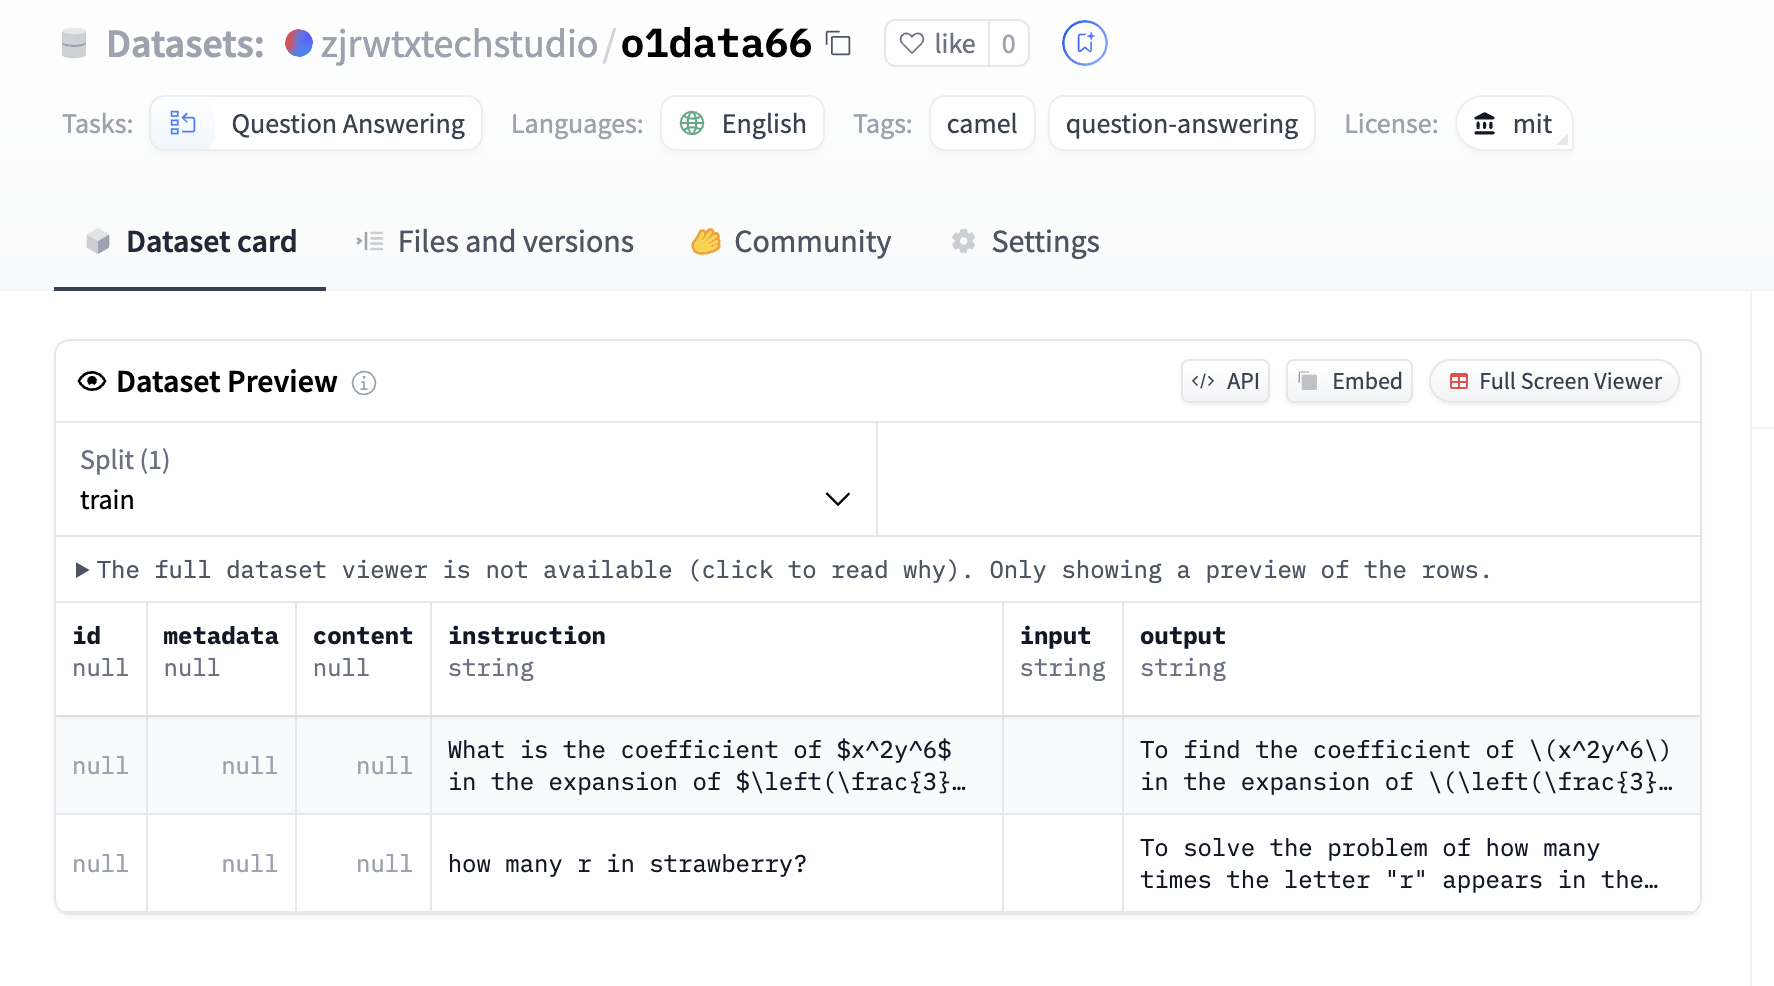

## 🌟 Highlights



This cookbook demonstrates the process of using **CAMEL's O1DataGenerator** to create high-quality question-answer pairs, similar to o1 thinking data. The notebook covers the following steps:

1. **Setup**: Installation of the `camel-ai` library and configuration of the OpenAI API key.
2. **Data Generation**: Utilization of the `O1DataGenerator` to generate answers for predefined questions using llm model.
3. **Data Transformation**: Conversion of the generated Q&A data into a format compliant with the Alpaca training data schema.
4. **Upload to Hugging Face**: Integration with Hugging Face to upload the transformed dataset, including the creation of a dataset card and metadata.

The cookbook also includes detailed instructions for setting up the environment, handling API keys, and configuring the Hugging Face dataset upload process. The final output is a dataset uploaded to Hugging Face, ready for sharing and further use in AI training tasks.

⭐ **Star the Repo**

If you find CAMEL useful or interesting, please consider giving it a star on [GitHub](https://github.com/camel-ai/camel)! Your stars help others find this project and motivate us to continue improving it.